In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!pip install 'monai==0.5.0'
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# unzip raw data into the "MONAI_DATA_DIRECTORY"
# import shutil
# shutil.unpack_archive("/content/drive/MyDrive/new_datasets/50.zip", "MONAI_DATA_DIRECTORY")

# !mv MONAI_DATA_DIRECTORY/50/images MONAI_DATA_DIRECTORY/50/imagesTr
# !mv MONAI_DATA_DIRECTORY/50/masks MONAI_DATA_DIRECTORY/50/labelsTr 

     |████████████████████████████████| 501kB 5.2MB/s 


# Import Modules and functions
# Setup imports

In [ ]:
# Import Molule and functios
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    AsChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import numpy as np
import glob

print_config()

MONAI version: 0.5.0
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2707407fed8c78ccb1c18d1e994a68580457219e

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# root_dir = './MONAI_DATA_DIRECTORY'
root_dir = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate'
# data_dir = os.path.join(root_dir, "50")
data_dir = root_dir
print(data_dir)

/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate


In [ ]:
import nibabel as nib

mask_test = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr_1/prostate_00.nii.gz')
print(mask_test.affine)

[[ 6.00000024e-01  2.62617619e-12 -1.18562840e-10 -9.81661072e+01]
 [ 2.62617445e-12  5.74392080e-01  1.15612781e+00 -1.05466675e+02]
 [ 1.77844180e-11 -1.73419192e-01  3.82927990e+00 -3.91753807e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
import nibabel as nib

def change_img_dim(keep):
  train_images = sorted(
  glob.glob(os.path.join(data_dir, "imagesTr",'prostate_*.nii.gz')))
  for img_path in train_images:
    img = nib.load(img_path)
    data = img.get_fdata()[:,:,:,keep]
    save_path = img_path.replace('imagesTr', 'imagesTr_'+str(keep))

    img_new = nib.Nifti1Image(data, img.affine)
    nib.save(img_new, save_path)
    print('successfully saved nifti image: ', save_path)

In [ ]:
# change_img_dim(keep=1)

In [ ]:
def change_labels(mode='keep both'):
  if mode == 'keep both':
    labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr",'prostate_*.nii.gz')))
    for img_path in labels:
      img = nib.load(img_path)
      data = img.get_fdata()
      save_path = img_path.replace('labelsTr', 'labelsTr_both')
      mask = np.array(data)
      mask[data == 2] = 1
      img_new = nib.Nifti1Image(mask, img.affine)
      nib.save(img_new, save_path)
      print('keep both','successfully saved nifti image: ', save_path)

  elif mode == 'keep 1':
    labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr",'prostate_*.nii.gz')))
    for img_path in labels:
      img = nib.load(img_path)
      data = img.get_fdata()
      save_path = img_path.replace('labelsTr', 'labelsTr_1')
      mask = np.array(data)
      mask[data == 2] = 0
      img_new = nib.Nifti1Image(mask, img.affine)
      nib.save(img_new, save_path)
      print('keep 1','successfully saved nifti image: ', save_path)

  elif mode == 'keep 2':
    labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr",'prostate_*.nii.gz')))
    for img_path in labels:
      img = nib.load(img_path)
      data = img.get_fdata()
      save_path = img_path.replace('labelsTr', 'labelsTr_2')
      mask = np.array(data)
      mask[data == 1] = 0
      mask[data == 2] = 1
      img_new = nib.Nifti1Image(mask, img.affine)
      nib.save(img_new, save_path)
      print('keep 2','successfully saved nifti image: ', save_path)

In [ ]:
# change_labels(mode='keep 2')

[0. 1. 2.]
[0. 1.]


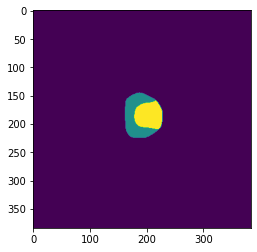

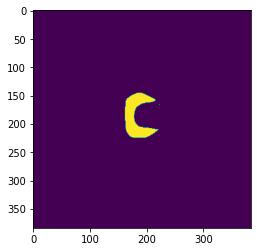

In [ ]:
slices = 4
dir = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_28.nii.gz'
dir_2 = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr_1/prostate_28.nii.gz'
img = nib.load(dir).get_fdata()[:,:,slices]
img_2 = nib.load(dir_2).get_fdata()[:,:,slices]
fig1 = plt.figure(1)
plt.imshow(img)
fig2 = plt.figure(2)
plt.imshow(img_2)
print(np.unique(img))
print(np.unique(img_2))

[0. 2.]


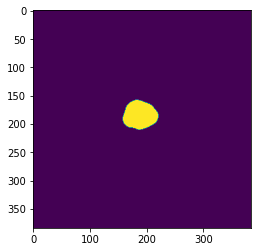

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_28.nii.gz').get_fdata()[:,:,8]
plt.imshow(img)
print(np.unique(img))

In [ ]:
from sklearn.model_selection import train_test_split

train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr_2",'prostate_*.nii.gz')))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr_2",'prostate_*.nii.gz')))
org_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr",'prostate_*.nii.gz'))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]


# train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=0)
train_files = data_dicts[:int(len(data_dicts)*0.8)]
val_files = data_dicts[int(len(data_dicts)*0.8):]
print(len(train_files))
print(len(val_files))

24
6


In [ ]:
# for path in org_labels:
#   lab = nib.load(path).get_fdata()
#   print(np.unique(lab))

In [ ]:
# for img_num in range(len(data_dicts)):
#   img = nib.load(data_dicts[img_num]['image']).get_fdata()[:,:,slices]
#   label = nib.load(data_dicts[img_num]['label']).get_fdata()[:,:,slices]
#   if img.shape != label.shape:
#     print(img.shape, label.shape)
#     print(data_dicts[img_num])

15
3 7 11
18 /content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr_2/prostate_34.nii.gz


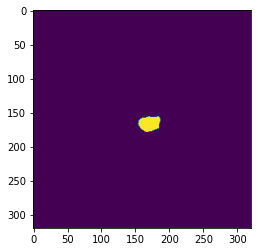

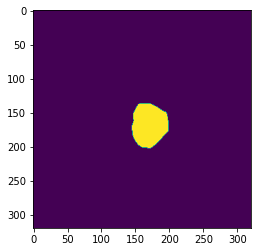

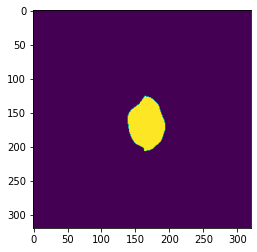

In [ ]:
i = 18
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr_2",'prostate_*.nii.gz')))


img_3d = nib.load(train_labels[i]).get_fdata()
print(img_3d.shape[2])
slice_1 = int(img_3d.shape[2]*(2/8))
slice_2 = int(img_3d.shape[2]*(4 / 8))
slice_3 = int(img_3d.shape[2]*(6 / 8))
print(slice_1,slice_2, slice_3)
img_1 = img_3d[:,:,slice_1]
img_2 = img_3d[:,:,slice_2]
img_3 = img_3d[:,:,slice_3]
plt.figure(1)
plt.imshow(img_1)
plt.figure(2)
plt.imshow(img_2)
plt.figure(3)
plt.imshow(img_3)
print(i, train_labels[i])
i += 1


#train_labels[11] (prostate_18), train_labels[19] (prostate_32)

24
6
[0. 1.]
[0. 1.]
[0. 1.]


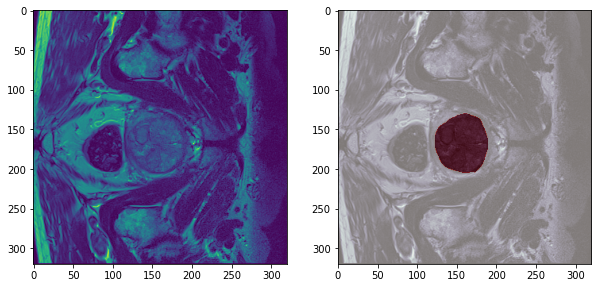

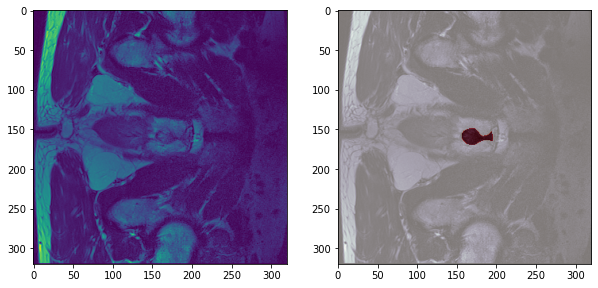

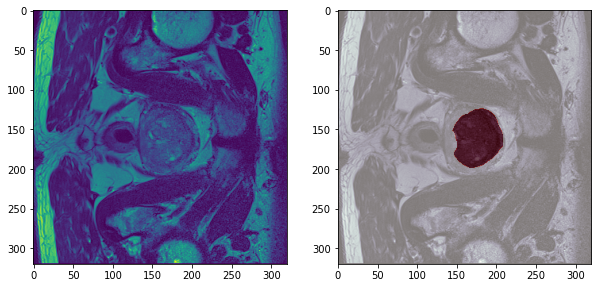

In [ ]:
import nibabel as nib
print(len(train_files))
print(len(val_files))
for i,img_num in enumerate([1,3,5]):  
  slices = 8
  img_3d = nib.load(val_files[img_num]['image']).get_fdata()
  label_3d = nib.load(val_files[img_num]['label']).get_fdata()
  # print(np.unique(img_3d))
  print(np.unique(label_3d))
  img = nib.load(val_files[img_num]['image']).get_fdata()[:,:,slices,0]
  label = nib.load(val_files[img_num]['label']).get_fdata()[:,:,slices]
  plt.figure(i,(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(img, cmap='bone')
  plt.imshow(label, cmap='Reds', alpha=0.5)

0.0 1502.0
(320, 320)
0.0 1.0


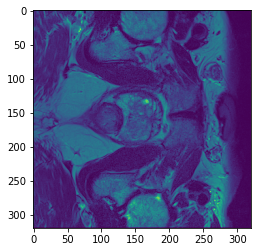

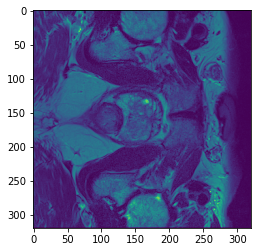

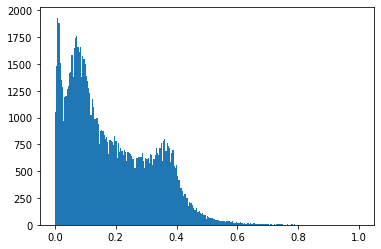

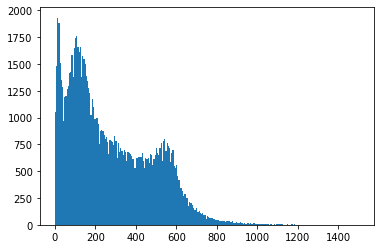

In [ ]:
import cv2
img_0 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_20.nii.gz').get_fdata()[:,:,4,0]
plt.figure(0)
plt.imshow(img_0)
print(np.min(img_0), np.max(img_0))
print(img_0.shape)
img_0_norm = cv2.normalize(img_0, np.zeros((384, 384)), 0, 1, cv2.NORM_MINMAX)
plt.figure(1)
plt.imshow(img_0_norm)
print(np.min(img_0_norm), np.max(img_0_norm))
plt.figure(2)
plt.hist(img_0_norm.flatten(), bins=256)
plt.figure(3)
plt.hist(img_0.flatten(), bins=256)
plt.show()

In [ ]:
def pr_normalized():
  path = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/'
  all_px_0 = np.array([])
  all_px_1 = np.array([])
  for i in range(50):
    try:
      img_0 = nib.load(path +'imagesTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').get_fdata()[:,:,:,0]
      img_1 = nib.load(path +'imagesTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').get_fdata()[:,:,:,1]
      img_1 = cv2.normalize(img_1, np.zeros(img_1.shape), -200,1150, cv2.NORM_MINMAX)
      label = nib.load(path +'labelsTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').get_fdata()[:,:,:]
      print('prostate_' + str(i).zfill(2))
      print('img_0: ', img_0.shape, (np.min(img_0), np.max(img_0)) )
      print('img_1: ', img_1.shape, (np.min(img_1), np.max(img_1)) )
      img_0_masked = np.array(img_0)
      img_0_masked[label==0]=0
      img_0_masked[label==2]=0
      new_px_0 = img_0_masked[img_0_masked != 0]
      img_1_masked = np.array(img_1)
      img_1_masked[label==0]=0
      img_1_masked[label==2]=0
      new_px_1 = img_1_masked[img_1_masked != 0]  
      print('img_0_masked: ', img_0_masked.shape, (np.min(img_0_masked), np.max(img_0_masked)) )
      print('img_1_masked: ', img_1_masked.shape, (np.min(img_1_masked), np.max(img_1_masked)),'\n' )
      all_px_0 = np.append(all_px_0, new_px_0.flatten())
      all_px_1 = np.append(all_px_1, new_px_1.flatten())
    except:
      pass

# pr_normalized()

In [ ]:
# plt.figure(0)
# plt.hist(all_px_0, bins=256)
# plt.title('T2')
# plt.figure(1)
# plt.hist(all_px_1, bins=256)
# plt.title('ADC')
# mean_0, std_0 = np.mean(all_px_0), np.std(all_px_0)
# mean_1, std_1 = np.mean(all_px_1), np.std(all_px_1)
# print('T2: ', mean_0 - 3*std_0, mean_0 + 3*std_0)
# print('ADC: ', mean_1 - 3*std_1, mean_1 + 3*std_1)
# plt.show()

In [ ]:
#label 1:
  # T2:  -90.7806911739778 911.8128448783345
  # ADC:  -33.92802330976576 916.4498007145583
  # norm range: -200 , 1150


#label 2
  # T2:  -26.068572460319785 699.1110910313573
  # ADC:  -13.436117673180433 697.3104804698983
  # norm range: -100, 950


In [ ]:
# img_0 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz').get_fdata()[:,:,:,0]
# img_1 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz').get_fdata()[:,:,:,1]
# img_0 = np.expand_dims(img_0,axis=3)
# img_1 = np.expand_dims(img_1,axis=3)
# print(img_0.shape)
# print(img_1.shape)
# img_con = np.append(img_0,img_1, axis=3)
# print(img_0.shape)
# print(img_1.shape)
# print(img_con.shape)
# plt.imshow(img_con[:,:,8,0])

In [ ]:
def save_normalized(keep):
  path = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/'
  for i in range(50):
    try:
      affine = nib.load(path +'imagesTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').affine
      img_0 = nib.load(path +'imagesTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').get_fdata()[:,:,:,0]
      img_1 = nib.load(path +'imagesTr/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz').get_fdata()[:,:,:,1]
      if keep == 1:  
        img_1 = cv2.normalize(img_1, np.zeros(img_1.shape), -200,1150, cv2.NORM_MINMAX)
      elif keep == 2:
        img_1 = cv2.normalize(img_1, np.zeros(img_1.shape), -100,950, cv2.NORM_MINMAX)
      img_0 = np.expand_dims(img_0,axis=3)
      img_1 = np.expand_dims(img_1,axis=3)
      img_con = np.append(img_0,img_1, axis=3)
      if keep == 1:
        save_path = path +'imagesTr_1/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz'
        img_con = nib.Nifti1Image(img_con, affine)
        nib.save(img_con, save_path)
        print(f'images norm_1 number {i} saved at {save_path}')
      elif keep == 2:
        save_path = path +'imagesTr_2/'+ 'prostate_' + str(i).zfill(2) + '.nii.gz'
        img_con = nib.Nifti1Image(img_con, affine)
        nib.save(img_con, save_path)
        print(f'images norm_2 number {i} saved at {save_path}')
    except:
      pass

# save_normalized(keep=2)

## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys=["image"]),
        AddChanneld(keys=["label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 0.3), mode=("bilinear", "nearest")), #0.5
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-26, a_max=700,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96,96,96), #64
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
     
     
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys=["image"]),
        AddChanneld(keys=["label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 0.3), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-26, a_max=700,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:472: UserWarning: Modifying image pixdim from [0.75       0.74999964 2.9999986  1.        ] to [  0.75         0.74999965   2.99999861 157.50724574]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


image shape: torch.Size([1, 2, 192, 192, 171]), label shape: torch.Size([1, 1, 192, 192, 171])
image shape: torch.Size([192, 192, 171]), label shape: torch.Size([192, 192, 171])
[0. 1.]


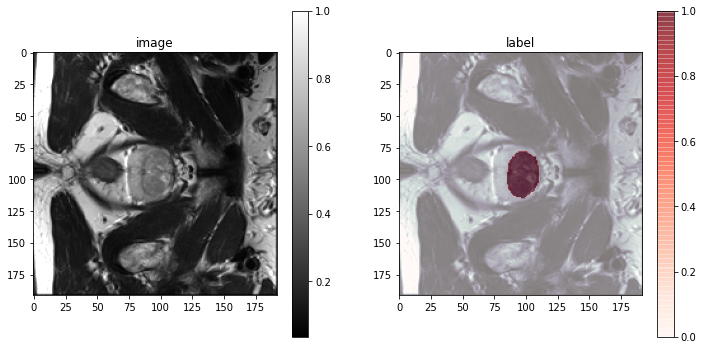

In [ ]:
# check_ds = Dataset(data=train_files, transform=train_transforms)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
aaa = check_data["image"]
labelaaa = check_data["label"]
print(f"image shape: {aaa.shape}, label shape: {labelaaa.shape}")
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
slices = 56
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slices], cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(image[:, :, slices], cmap='bone')
plt.imshow(label[:, :, slices], cmap='Reds', alpha=0.5)
plt.colorbar()
print(np.unique(label[:,:,slices]))
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

# Dataloader batch_size
- Use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/monai/data/dataset.py:527: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:472: UserWarning: Modifying image pixdim from [0.6       0.6000003 4.0000024 1.       ] to [  0.60000002   0.60000034   4.00000227 149.31681629]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:472: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.84918933]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/usr/local/lib/python3.7/dist-packages/monai/data/utils.py:472: UserWarning: Modifying image pixdim from [0.6        0.60000014 4.0000005  1.        ] to [  0.60000002   0.60000017   4.00000043 128.8161199 ]
  warnings.warn(f"Modifying image pixdim f

# load first batch of data_loader and print shape of batch-data.

In [ ]:
i = 0
for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"],
        batch_data["label"],
    )
    print(inputs.shape,labels.shape)
    i += 1
    if i == 10:
      break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])
torch.Size([8, 2, 96, 96, 96]) torch.Size([8, 1, 96, 96, 96])


## Create Model, Loss, Optimizer
- standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

In [ ]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

## Execute a typical PyTorch training process

- Notice! roi_size in sliding_window_inference Is a multiple of 32
 for example(96,96,96) or (192,192,192), etc.

In [ ]:
max_epochs = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 average loss: 0.5428
----------
epoch 2/10
epoch 2 average loss: 0.4741
saved new best metric model
current epoch: 2 current mean dice: 0.1524
best mean dice: 0.1524 at epoch: 2
----------
epoch 3/10
epoch 3 average loss: 0.4213
----------
epoch 4/10
epoch 4 average loss: 0.3977
current epoch: 4 current mean dice: 0.0093
best mean dice: 0.1524 at epoch: 2
----------
epoch 5/10
epoch 5 average loss: 0.3632
----------
epoch 6/10
epoch 6 average loss: 0.3253
saved new best metric model
current epoch: 6 current mean dice: 0.4258
best mean dice: 0.4258 at epoch: 6
----------
epoch 7/10
epoch 7 average loss: 0.2942
----------
epoch 8/10
epoch 8 average loss: 0.2846
saved new best metric model
current epoch: 8 current mean dice: 0.5845
best mean dice: 0.5845 at epoch: 8
----------
epoch 9/10
epoch 9 average loss: 0.2655
----------
epoch 10/10
epoch 10 average loss: 0.2649
current epoch: 10 current mean dice: 0.5667
best mean dice: 0.5845 at epoch: 8


# Load saved model with best Dice score and resume training with lr=1e-4

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
max_epochs = 50
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 average loss: 0.1645
----------
epoch 2/50
epoch 2 average loss: 0.1548
current epoch: 2 current mean dice: 0.7570
best mean dice: 0.7904 at epoch: 62
----------
epoch 3/50
epoch 3 average loss: 0.1381
----------
epoch 4/50
epoch 4 average loss: 0.1373
current epoch: 4 current mean dice: 0.7861
best mean dice: 0.7904 at epoch: 62
----------
epoch 5/50
epoch 5 average loss: 0.1509
----------
epoch 6/50
epoch 6 average loss: 0.1158
current epoch: 6 current mean dice: 0.7666
best mean dice: 0.7904 at epoch: 62
----------
epoch 7/50
epoch 7 average loss: 0.1156
----------
epoch 8/50
epoch 8 average loss: 0.1271
current epoch: 8 current mean dice: 0.7633
best mean dice: 0.7904 at epoch: 62
----------
epoch 9/50
epoch 9 average loss: 0.1494
----------
epoch 10/50
epoch 10 average loss: 0.1468
current epoch: 10 current mean dice: 0.7791
best mean dice: 0.7904 at epoch: 62
----------
epoch 11/50
epoch 11 average loss: 0.1396
----------
epoch 12/50
epoch 12 average loss: 0.1497
current 

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7904 at epoch: 62


## Plot the loss and metric

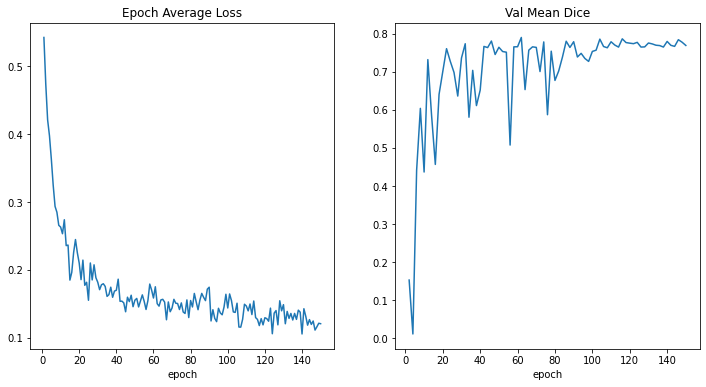

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (320, 320, 320)
        sw_batch_size = 1
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

In [ ]:
def cross_val(k=5, epochs=(100,50)):
  dices = 0
  for i in range(k):
    dices += model_train(epochs = epochs)
  print(dices)
  print(dices/k)